In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate# GridSearchCV já está importado
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer # Import FunctionTransformer
from sklearn.feature_selection import SelectFromModel # Mantenha se for usar, senão pode remover
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, f1_score, precision_score, recall_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Leitura dos arquivos

In [2]:
df = pd.read_csv('/mnt/c/Users/AcerGamer/Downloads/Tuberculose/Projeto-Tuberculose/dados/arquivos_csv/df_treino_final_para_modelo.csv', low_memory=False)

In [3]:
porcentagem_nulos = df.isnull().mean() * 100
colunas_para_remover = porcentagem_nulos[porcentagem_nulos > 30].index
df = df.drop(columns=colunas_para_remover)
print(f"Restaram {df.shape[1]} colunas após remoção de ausentes.")

Restaram 11 colunas após remoção de ausentes.


In [4]:
print("\n--- df info ---")
print(df.info())


--- df info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931299 entries, 0 to 931298
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   FORMA       931111 non-null  float64
 1   CS_SEXO     931299 non-null  object 
 2   CS_RACA     921714 non-null  object 
 3   NU_IDADE_N  931096 non-null  float64
 4   HIV         929546 non-null  object 
 5   AGRAVAIDS   922211 non-null  float64
 6   AGRAVALCOO  922687 non-null  float64
 7   RAIOX_TORA  921472 non-null  object 
 8   BACILOSC_E  931133 non-null  object 
 9   CULTURA_ES  931133 non-null  object 
 10  NU_ANO      931299 non-null  int64  
dtypes: float64(4), int64(1), object(6)
memory usage: 78.2+ MB
None


In [5]:
print("\nPrimeiras linhas df:")
display(df.head())


Primeiras linhas df:


,FORMA,CS_SEXO,CS_RACA,NU_IDADE_N,HIV,AGRAVAIDS,AGRAVALCOO,RAIOX_TORA,BACILOSC_E,CULTURA_ES,NU_ANO
0,1.0,F,Parda,4011.0,Não realizado,2.0,2.0,1.0,1.0,4.0,2020
1,1.0,M,Indígena,4046.0,Não Reagente,2.0,2.0,4.0,1.0,4.0,2020
2,1.0,F,Parda,4065.0,Não realizado,2.0,1.0,1.0,1.0,4.0,2020
3,1.0,M,Branca,4059.0,Não Reagente,2.0,1.0,1.0,3.0,2.0,2020
4,1.0,M,Parda,4035.0,Não Reagente,2.0,2.0,1.0,1.0,4.0,2021


In [6]:
print("\nContagem de 'FORMA' no df:")
df['FORMA'].value_counts()


Contagem de 'FORMA' no df:


FORMA
1.0    429028
4.0    429028
2.0     56767
3.0     16288
Name: count, dtype: int64

In [7]:
df['FORMA'] = df['FORMA'].astype(str)

# fim da leitura de dados

In [8]:
# --- Seleção de Colunas para o Modelo ---
colunas_modelo = [
    'FORMA',            # variável alvo
    'CS_SEXO',
    'CS_RACA',
    'NU_IDADE_N',
    'HIV',
    'AGRAVAIDS',
    'AGRAVALCOO',
    'RAIOX_TORA',
    'BACILOSC_E',
    'CULTURA_ES',
    'NU_ANO'            # ano da notificação
]
df_modelo = df[colunas_modelo].copy()

# --- Conversão da coluna NU_IDADE_N ---

In [9]:
def converter_idade_para_modelo(nu_idade_n):
    if pd.isna(nu_idade_n) or int(nu_idade_n) == 0: # Trata NaNs ou 0000 como idade ignorada
        return np.nan # Retorna np.nan para ser imputado posteriormente

    nu_idade_n = int(nu_idade_n) # Garante que é inteiro para as operações
    unidade = nu_idade_n // 1000
    valor = nu_idade_n % 1000

    if unidade == 1:  # Horas
        return valor / (24 * 365)
    elif unidade == 2:  # Dias
        return valor / 365
    elif unidade == 3:  # Meses
        return valor / 12
    elif unidade == 4:  # Anos
        return valor
    else: # Idade ignorada ou inválida (ex: '0000')
        return np.nan

In [10]:
# Aplica a função para criar a coluna de idade em anos correta
df_modelo['NU_IDADE_ANOS_CORRETA'] = df_modelo['NU_IDADE_N'].apply(converter_idade_para_modelo)

In [11]:
# Preencher NaNs na nova coluna de idade (se houver, após a conversão) com a mediana
mediana_idade_correta = df_modelo['NU_IDADE_ANOS_CORRETA'].median()
df_modelo['NU_IDADE_ANOS_CORRETA'] = df_modelo['NU_IDADE_ANOS_CORRETA'].fillna(mediana_idade_correta)

In [12]:
# Criar Faixa Etária a partir da idade correta
bins = [0, 18, 35, 50, 65, 120]
labels = ['Jovem', 'Adulto Jovem', 'Adulto', 'Idoso', 'Muito Idoso']
df_modelo['faixa_etaria'] = pd.cut(df_modelo['NU_IDADE_ANOS_CORRETA'], bins=bins, labels=labels, right=False, include_lowest=True)

In [13]:
# 2. Criar um contador de comorbidades/fatores de risco
# Garantir que AGRAVAIDS e AGRAVALCOO sejam numéricos antes de operar
df_modelo['AGRAVAIDS'] = pd.to_numeric(df_modelo['AGRAVAIDS'], errors='coerce').fillna(0.0)
df_modelo['AGRAVALCOO'] = pd.to_numeric(df_modelo['AGRAVALCOO'], errors='coerce').fillna(0.0)
df_modelo['total_comorbidades'] = (df_modelo['AGRAVAIDS'] == 1.0).astype(int) + \
                                  (df_modelo['AGRAVALCOO'] == 1.0).astype(int)

In [14]:
# 3. Criar feature de interação para HIV com AIDS
# Preencher NaNs antes da comparação para 'HIV'
df_modelo['HIV'] = df_modelo['HIV'].fillna('Não Informado')

df_modelo['hiv_positivo_com_aids'] = ((df_modelo['HIV'] == 'Reagente') & (df_modelo['AGRAVAIDS'] == 1.0))

# Remover colunas originais que foram transformadas/substituídas
df_modelo = df_modelo.drop(columns=['NU_IDADE_N', 'AGRAVAIDS', 'AGRAVALCOO'])

In [15]:
# Garantir que a coluna FORMA é float para poder adicionar 4.0
df_modelo['FORMA'] = df_modelo['FORMA'].fillna(0).astype(float) # Preenche NaNs com 0 e converte para float

In [16]:
print(f"Número de linhas em df_modelo antes da filtragem de FORMA=0.0: {len(df_modelo)}")
df_modelo = df_modelo[df_modelo['FORMA'] != 0.0].copy() # Filtra as linhas onde FORMA é 0.0
print(f"Número de linhas em df_modelo após a filtragem de FORMA=0.0: {len(df_modelo)}")

Número de linhas em df_modelo antes da filtragem de FORMA=0.0: 931299
Número de linhas em df_modelo após a filtragem de FORMA=0.0: 931299


# --- Preparação dos Dados para o Modelo ---

In [17]:
# Preencher NaNs da FORMA com a moda antes de converter e codificar.
# Isso garante que não haverá IntCastingNaNError.
# A moda é uma boa escolha para variáveis categóricas/discretas como 'FORMA'.
df_modelo['FORMA'] = df_modelo['FORMA'].fillna(df_modelo['FORMA'].mode()[0])

In [18]:
df_modelo['FORMA'].unique()

array([1., 2., 3., 4.])

In [19]:
# --- Mapeamento da Variável Alvo para Binário ---
# Mapear os valores de 'FORMA' para as novas classes binárias
# 1.0 (Pulmonar), 2.0 (Extrapulmonar), 3.0 (Mista) são agrupados como 'nao_saudavel'
# 4.0 é considerado 'saudavel'
mapeamento_forma = {
    1.0: 'nao_saudavel',
    2.0: 'nao_saudavel',
    3.0: 'nao_saudavel',
    4.0: 'saudavel'
}
df_modelo['FORMA_BINARIA'] = df_modelo['FORMA'].map(mapeamento_forma)

# Verificar a distribuição da nova coluna
print("Distribuição da nova variável alvo 'FORMA_BINARIA':")
print(df_modelo['FORMA_BINARIA'].value_counts(dropna=False))
print("\n")

# --- Definição de X e y ---
# y é a nossa nova variável alvo binária
y = df_modelo['FORMA_BINARIA'].copy() # Usar a coluna binária como alvo
# X contém todas as features, removendo a coluna alvo original e a nova
X = df_modelo.drop(['FORMA', 'FORMA_BINARIA'], axis=1)

print("Variável alvo 'y' e features 'X' criadas para o modelo binário.")

Distribuição da nova variável alvo 'FORMA_BINARIA':
FORMA_BINARIA
nao_saudavel    502271
saudavel        429028
Name: count, dtype: int64


Variável alvo 'y' e features 'X' criadas para o modelo binário.


In [20]:
# ---- Codificar a variável alvo 'y' para 0 e 1 ----
# A variável y já contém 'nao_saudavel' e 'saudavel'
le = LabelEncoder()
y_encoded = le.fit_transform(y) # y_encoded agora será 0 ('nao_saudavel') e 1 ('saudavel')

# Split dos dados em treino e teste - ISSO DEVE SER FEITO AQUI!
# Usar y_encoded para a estratificação
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.02, stratify=y_encoded, random_state=1953)
#Dividir os 2% restantes em 1% para validação e 1% para teste (0.5 de 2% é 1%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=1953)

print("Divisão de dados 98/1/1 (Treino/Validação/Teste) concluída.")
print(f"Shape de X_train: {X_train.shape}, Shape de y_train: {y_train.shape}")
print(f"Shape de X_val: {X_val.shape}, Shape de y_val: {y_val.shape}")
print(f"Shape de X_test: {X_test.shape}, Shape de y_test: {y_test.shape}")

Divisão de dados 98/1/1 (Treino/Validação/Teste) concluída.
Shape de X_train: (912673, 11), Shape de y_train: (912673,)
Shape de X_val: (9313, 11), Shape de y_val: (9313,)
Shape de X_test: (9313, 11), Shape de y_test: (9313,)


In [21]:
print(f"Classes codificadas pelo LabelEncoder: {le.classes_}")
print("O LabelEncoder atribui 0 para 'nao_saudavel' e 1 para 'saudavel'.")

Classes codificadas pelo LabelEncoder: ['nao_saudavel' 'saudavel']
O LabelEncoder atribui 0 para 'nao_saudavel' e 1 para 'saudavel'.


In [22]:
# A célula de divisão de dados foi movida para a célula anterior para garantir a ordem correta das operações.

In [23]:
print("\nDistribuição das classes nos splits:")
splits = {'Treino': y_train, 'Validação': y_val, 'Teste': y_test}
for name, y_split in splits.items():
    print(f"--- {name} ---")
    unique, counts = np.unique(y_split, return_counts=True)
    for label_num, count in zip(unique, counts):
        label_orig = le.inverse_transform([label_num])[0]
        print(f"Classe {label_orig} ({label_num}): {count} amostras ({count/len(y_split):.2%})")



Distribuição das classes nos splits:
--- Treino ---
Classe nao_saudavel (0): 492226 amostras (53.93%)
Classe saudavel (1): 420447 amostras (46.07%)
--- Validação ---
Classe nao_saudavel (0): 5022 amostras (53.92%)
Classe saudavel (1): 4291 amostras (46.08%)
--- Teste ---
Classe nao_saudavel (0): 5023 amostras (53.94%)
Classe saudavel (1): 4290 amostras (46.06%)


In [24]:
# Identificar colunas numéricas e categóricas (APÓS a engenharia de features)

numeric_features = ['NU_ANO', 'NU_IDADE_ANOS_CORRETA', 'total_comorbidades']

# Adicione as colunas que você identificou como categóricas/ordinais
categorical_features = [
    'CS_SEXO', 'CS_RACA', 'HIV', 'faixa_etaria', 'hiv_positivo_com_aids',
    'RAIOX_TORA', 'BACILOSC_E', 'CULTURA_ES'
]

# Certifique-se de que não há sobreposição ou colunas faltando
# (pode ser útil um print(X.columns) para verificar todas as colunas em X)
numeric_features = [f for f in numeric_features if f in X.columns]
categorical_features = [f for f in categorical_features if f in X.columns]

print(f"Features numéricas que serão usadas: {numeric_features}")
print(f"Features categóricas que serão usadas: {categorical_features}")

Features numéricas que serão usadas: ['NU_ANO', 'NU_IDADE_ANOS_CORRETA', 'total_comorbidades']
Features categóricas que serão usadas: ['CS_SEXO', 'CS_RACA', 'HIV', 'faixa_etaria', 'hiv_positivo_com_aids', 'RAIOX_TORA', 'BACILOSC_E', 'CULTURA_ES']


In [25]:
# --- Construção do Pipeline Avançado (com XGBoost e Imputação Melhorada) ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Imputa NaNs resultantes da conversão de idade
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Imputa NaNs nas categóricas
    # Explicitly convert to string before OneHotEncoding
    ('string_converter', FunctionTransformer(lambda x: x.astype(str), validate=False)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Manter colunas não especificadas (se houver)
)

## --- Definição da Estratégia de Superamostragem para SMOTE ---

In [26]:
# Criar o pipeline final usando o ImbPipeline

# --- ESTRATÉGIA DE SMOTE PARA CLASSIFICAÇÃO BINÁRIA ---
# Após o mapeamento, as classes são 'nao_saudavel' (0) e 'saudavel' (1).
# As classes estão um pouco desbalanceadas (aprox. 54% vs 46%).
# Vamos usar SMOTE para igualar o número de amostras da classe minoritária ('saudavel')
# ao da majoritária no conjunto de treino. A estratégia 'auto' faz exatamente isso.

pipeline_final = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2024, sampling_strategy='auto')),
    # Classificador XGBoost ajustado para classificação binária
    ('classifier', XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=2024,
                  n_estimators=100, max_depth=3, learning_rate=0.01,
                  subsample=0.2, colsample_bytree=0.8, tree_method='hist',
                  reg_alpha=0.1, reg_lambda=0.1)) # Adicionando regularização L1 e L2
])

In [27]:
# 1. Dividir o df_modelo em 5 partes (folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

# Criar uma lista para armazenar os 5 dataframes
dataframes = []

# Iterar sobre os folds para criar os 5 dataframes
for _, test_index in skf.split(df_modelo, df_modelo['FORMA_BINARIA']):
    dataframes.append(df_modelo.iloc[test_index].copy())

# Atribuir os dataframes a variáveis separadas (df1, df2, etc.)
df1, df2, df3, df4, df5 = dataframes

print("Dataframes divididos em 5 partes:")
for i, df_part in enumerate(dataframes, 1):
    print(f"  - df{i}: {len(df_part)} linhas")

Dataframes divididos em 5 partes:
  - df1: 186260 linhas
  - df2: 186260 linhas
  - df3: 186260 linhas
  - df4: 186260 linhas
  - df5: 186259 linhas


In [28]:
for i, df_part in enumerate(dataframes, 1):
    print(f"--- Caracterização do df{i} ---")
    print(df_part['FORMA_BINARIA'].value_counts(normalize=True))
    print("\n")

--- Caracterização do df1 ---
FORMA_BINARIA
nao_saudavel    0.539327
saudavel        0.460673
Name: proportion, dtype: float64


--- Caracterização do df2 ---
FORMA_BINARIA
nao_saudavel    0.539321
saudavel        0.460679
Name: proportion, dtype: float64


--- Caracterização do df3 ---
FORMA_BINARIA
nao_saudavel    0.539321
saudavel        0.460679
Name: proportion, dtype: float64


--- Caracterização do df4 ---
FORMA_BINARIA
nao_saudavel    0.539321
saudavel        0.460679
Name: proportion, dtype: float64


--- Caracterização do df5 ---
FORMA_BINARIA
nao_saudavel    0.539324
saudavel        0.460676
Name: proportion, dtype: float64




In [29]:
results = []

for i, df_part in enumerate(dataframes, 1):
    print(f"--- Treinando e Avaliando Modelo na Base {i} ---")

    # 1. Definir X e y para o dataframe atual
    y_part = le.transform(df_part['FORMA_BINARIA'])
    X_part = df_part.drop(['FORMA', 'FORMA_BINARIA'], axis=1)

    # 2. Dividir em treino (80%), validação (10%) e teste (10%)
    X_train_part, X_temp_part, y_train_part, y_temp_part = train_test_split(
        X_part, y_part, test_size=0.2, stratify=y_part, random_state=1953
    )
    X_val_part, X_test_part, y_val_part, y_test_part = train_test_split(
        X_temp_part, y_temp_part, test_size=0.5, stratify=y_temp_part, random_state=1953
    )

    # 3. Treinar o pipeline
    pipeline_final.fit(X_train_part, y_train_part)

    # 4. Fazer previsões e avaliar
    y_pred_part = pipeline_final.predict(X_test_part)

    # 5. Calcular e armazenar as métricas
    precision = precision_score(y_test_part, y_pred_part, average='macro')
    recall = recall_score(y_test_part, y_pred_part, average='macro')
    f1 = f1_score(y_test_part, y_pred_part, average='macro')

    results.append({
        'Base': f'Base {i}',
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

    print(f"Resultados para a Base {i} calculados.\n")

# Converter a lista de resultados em um DataFrame do pandas
results_df = pd.DataFrame(results)

--- Treinando e Avaliando Modelo na Base 1 ---
Resultados para a Base 1 calculados.

--- Treinando e Avaliando Modelo na Base 2 ---
Resultados para a Base 2 calculados.

--- Treinando e Avaliando Modelo na Base 3 ---
Resultados para a Base 3 calculados.

--- Treinando e Avaliando Modelo na Base 4 ---
Resultados para a Base 4 calculados.

--- Treinando e Avaliando Modelo na Base 5 ---
Resultados para a Base 5 calculados.



In [41]:
print("--- Tabela de Resultados ---")
display(results_df)

print("\n--- Média e Desvio Padrão das Métricas ---")
display(results_df.describe().loc[['mean', 'std']])

f1_macro = f1_score(y_test_part, y_pred_part, average='macro')
f1_micro = f1_score(y_test_part, y_pred_part, average='micro')
print("\n--- Valores F1-macro e F1-micro ---")
print(f"F1-Macro: {f1_macro:.4f}")
print(f"F1-Micro: {f1_micro:.4f}")

--- Tabela de Resultados ---


,Base,Precision,Recall,F1-score
0,Base 1,0.999592,0.999652,0.999622
1,Base 2,0.999883,0.999900,0.999892
2,Base 3,0.999942,0.999950,0.999946
3,Base 4,0.999883,0.999900,0.999892
4,Base 5,0.999709,0.999751,0.999730



--- Média e Desvio Padrão das Métricas ---


,Precision,Recall,F1-score
mean,0.999802,0.999831,0.999816
std,0.000146,0.000125,0.000136



--- Valores F1-macro e F1-micro ---
F1-Macro: 0.9997
F1-Micro: 0.9997


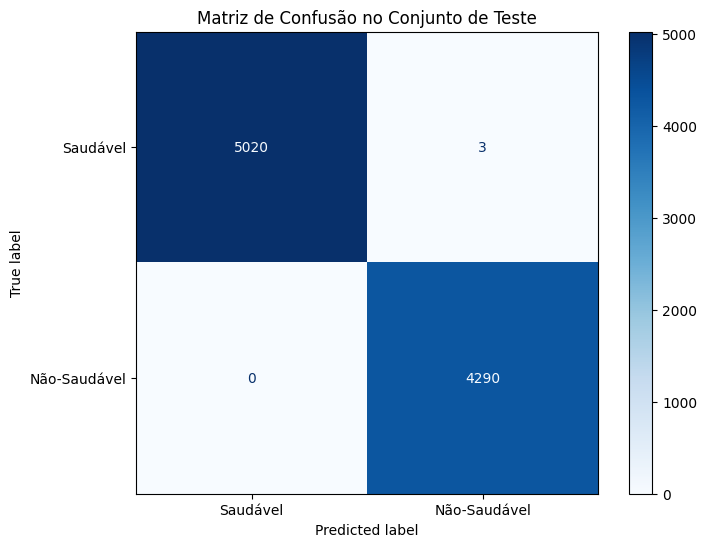

In [33]:
y_pred = pipeline_final.predict(X_test)

display_labels = ['Saudável', 'Não-Saudável']

fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.title('Matriz de Confusão no Conjunto de Teste')
plt.show()

In [40]:
f1_macro = f1_score(y_test_part, y_pred_part, average='macro')
f1_micro = f1_score(y_test_part, y_pred_part, average='micro')
print("\n--- Valores F1-macro e F1-micro ---")
print(f"F1-Macro: {f1_macro:.4f}")
print(f"F1-Micro: {f1_micro:.4f}")


--- Valores F1-macro e F1-micro ---
F1-Macro: 0.9997
F1-Micro: 0.9997


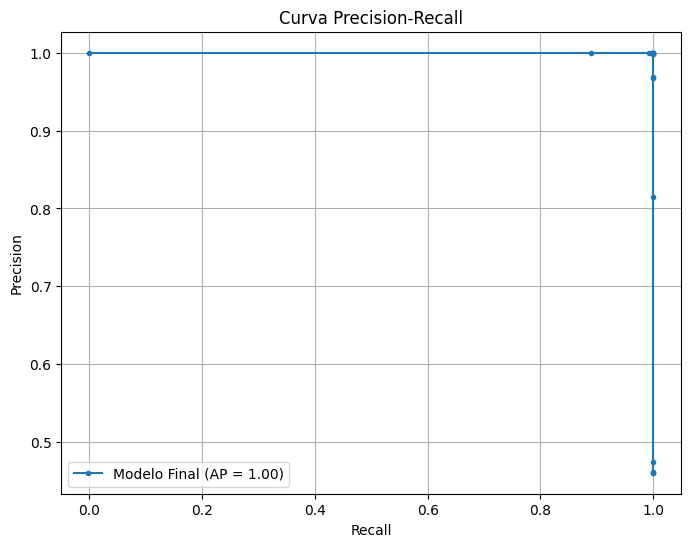

Average Precision (AP): 1.0000


In [36]:
y_proba = pipeline_final.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba)
average_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Modelo Final (AP = {average_precision:.2f})')

plt.title('Curva Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

print(f"Average Precision (AP): {average_precision:.4f}")